In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import time
import os
from itertools import product
from pylab import rcParams
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.deterministic import CalendarFourier
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier

In [9]:
datafolder = '/Users/nurik/Documents/kaggle/store-sales-time-series-forecasting/'

In [10]:
oil= pd.read_csv(os.path.join(datafolder,'oil.csv'))
holidays_events=pd.read_csv(os.path.join(datafolder,'holidays_events.csv'))
stores= pd.read_csv(os.path.join(datafolder,'stores.csv'))
train= pd.read_csv(os.path.join(datafolder,'train.csv'))
test= pd.read_csv(os.path.join(datafolder,'test.csv'))
transactions= pd.read_csv(os.path.join(datafolder,'transactions.csv'))

In [16]:
train[(train['family']=='AUTOMOTIVE') & (train['store_nbr']==1)]

id        date  store_nbr      family  sales  onpromotion
0              0  2013-01-01          1  AUTOMOTIVE    0.0            0
1782        1782  2013-01-02          1  AUTOMOTIVE    2.0            0
3564        3564  2013-01-03          1  AUTOMOTIVE    3.0            0
5346        5346  2013-01-04          1  AUTOMOTIVE    3.0            0
7128        7128  2013-01-05          1  AUTOMOTIVE    5.0            0
...          ...         ...        ...         ...    ...          ...
2991978  2991978  2017-08-11          1  AUTOMOTIVE    1.0            0
2993760  2993760  2017-08-12          1  AUTOMOTIVE    6.0            0
2995542  2995542  2017-08-13          1  AUTOMOTIVE    1.0            0
2997324  2997324  2017-08-14          1  AUTOMOTIVE    1.0            0
2999106  2999106  2017-08-15          1  AUTOMOTIVE    4.0            0

[1684 rows x 6 columns]

## Calendar and moving average

In [8]:
oil['date'].max()

'2017-08-31'

In [9]:
oil['date'].min()

'2013-01-01'

In [10]:
calendar = pd.DataFrame(index=pd.date_range('2013-01-01','2017-08-31'))

In [11]:
df_oil = pd.read_csv(datafolder+'oil.csv',parse_dates=['date'],index_col='date',infer_datetime_format=True)

In [12]:
df_oil['ma_oil'] = df_oil['dcoilwtico'].rolling(7).mean()

In [13]:
calendar = calendar.merge(df_oil,how='left',left_index=True,right_index=True)

In [14]:
calendar['ma_oil'].fillna(method='ffill',inplace=True)

In [15]:
calendar['dofw'] = calendar.index.dayofweek

In [16]:
df_events = pd.read_csv(datafolder+'holidays_events.csv',parse_dates=['date'],infer_datetime_format=True)

In [17]:
df_events['date'] = df_events['date'].replace({'2013-04-29' : 
                                         pd.to_datetime('2013-03-29')})

In [18]:
df_events = df_events.set_index('date').sort_index()

In [19]:
df_events = df_events[df_events.locale == 'National']

In [26]:
df_events = df_events.groupby(df_events.index).first()

In [16]:
df_events = df_events.groupby(df_events.index).first()

In [17]:
calendar['wd'] = True

In [18]:
calendar.loc[calendar['dofw']>4,'wd'] = False

In [19]:
calendar = calendar.merge(df_events,how='left',left_index=True,right_index=True)

In [20]:
calendar.loc[calendar.type == 'Bridge'  , 'wd'] = False
calendar.loc[calendar.type == 'Work Day', 'wd'] = True
calendar.loc[calendar.type == 'Transfer', 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True ), 'wd'] = True

### Modeling Data

#### Ridge

In [21]:
df_train = pd.read_csv(datafolder+'train.csv',usecols=['store_nbr','family','date','sales'],dtype={'store_nbr':'category','family':'category','sales':'float32'},parse_dates=['date'],infer_datetime_format=True)

In [22]:
df_train.date = df_train.date.dt.to_period('D')

In [23]:
df_train = df_train.set_index(['store_nbr','family','date']).sort_index()

In [24]:
df_train

sales
store_nbr family     date                 
1         AUTOMOTIVE 2013-01-01   0.000000
                     2013-01-02   2.000000
                     2013-01-03   3.000000
                     2013-01-04   3.000000
                     2013-01-05   5.000000
...                                    ...
9         SEAFOOD    2017-08-11  23.830999
                     2017-08-12  16.859001
                     2017-08-13  20.000000
                     2017-08-14  17.000000
                     2017-08-15  16.000000

[3000888 rows x 1 columns]

In [25]:
df_test = pd.read_csv(datafolder+'test.csv',usecols=['store_nbr','family','date'],dtype={'store_nbr':'category','family':'category'},parse_dates=['date'],infer_datetime_format=True)
df_test.date = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr','family','date']).sort_index()



In [26]:
end_date='2017-08-15'
start_date='2017-04-01'

In [27]:
y = df_train.unstack(['store_nbr','family']).loc[start_date:end_date]

In [28]:
fourier = CalendarFourier(freq='W',order=4)
dp = DeterministicProcess(index = y.index,
                         constant=False,
                         order = 1,
                         seasonal=False,
                         additional_terms=[fourier],
                         drop=True)
X = dp.in_sample()

In [29]:
X['ma_oil'] = calendar.loc[start_date:end_date]['ma_oil'].values

In [30]:
X['dofw'] = calendar.loc[start_date:end_date]['dofw'].values
X['wd'] = calendar.loc[start_date:end_date]['wd'].values
X['type'] = calendar.loc[start_date:end_date]['type'].values

In [31]:
X = pd.get_dummies(X,columns=['wd'],drop_first=True)

In [32]:
X = pd.get_dummies(X,columns=['type'],drop_first=True)

In [33]:
model = Ridge(alpha=0.1,solver='auto',normalize=True,fit_intercept=True)
model.fit(X,y)

Ridge(alpha=0.1, normalize=True)

In [34]:
y_pred = pd.DataFrame(model.predict(X),index=X.index,columns=y.columns)

In [35]:
y_pred = y_pred.stack(['store_nbr','family']).reset_index()

In [36]:
y_target = y.stack(['store_nbr','family']).reset_index().copy()

In [37]:
y_target['sales_pred'] = y_pred['sales'].clip(0.)

In [38]:
y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred']))

family
AUTOMOTIVE                    0.254437
BABY CARE                     0.066811
BEAUTY                        0.262242
BEVERAGES                     0.193775
BOOKS                         0.027257
BREAD/BAKERY                  0.120688
CELEBRATION                   0.288658
CLEANING                      0.211323
DAIRY                         0.131788
DELI                          0.104748
EGGS                          0.140102
FROZEN FOODS                  0.154032
GROCERY I                     0.206082
GROCERY II                    0.344541
HARDWARE                      0.273377
HOME AND KITCHEN I            0.256074
HOME AND KITCHEN II           0.218109
HOME APPLIANCES               0.152477
HOME CARE                     0.117968
LADIESWEAR                    0.255371
LAWN AND GARDEN               0.237559
LINGERIE                      0.396600
LIQUOR,WINE,BEER              0.620801
MAGAZINES                     0.250703
MEATS                         0.116594
PERSONAL CARE     

<AxesSubplot:xlabel='date'>

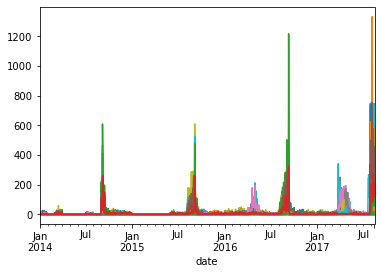

In [57]:
df_train.unstack(['store_nbr','family']).loc['2014':].loc(axis=1)['sales',:,'SCHOOL AND OFFICE SUPPLIES'].plot(legend=None)

In [58]:
from joblib import Parallel, delayed
import warnings

from sklearn.linear_model import Ridge
from sklearn.ensemble     import RandomForestRegressor

In [67]:
y.shape[1]

1782

In [69]:
y.iloc[:,2].name[2]

'BEAUTY'

In [71]:
class CustomRegress():
    def __init__(self,n_jobs=-1,verbose=0):
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.estimators_ = None
    def _estimators_(self,X,y):
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES':
            model = RandomForestRegressor(n_estimators=300,n_jobs=-1,random_state=1)
        else:
            model = Ridge(fit_intercept=True,solver='auto',alpha=0.5,normalize=True)
        model.fit(X,y)
        return model
    def fit(self,X,y):
        self.estimators_ = Parallel(n_jobs=self.n_jobs,verbose=self.verbose)(delayed(self._estimators_)(X,y.iloc[:,i]) for i in range(y.shape[1]))
        return 
    def predict(self,X):
        y_pred = Parallel(n_jobs = self.n_jobs,verbose=self.verbose)(delayed(e.predict)(X) for e in self.estimators_)
        return np.stack(y_pred,axis=1)

In [74]:
model = CustomRegress(n_jobs=-1,verbose=0)
model.fit(X,y)
y_pred = pd.DataFrame(model.predict(X),index=X.index,columns=y.columns)

In [75]:
y_pred   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()
y_target['sales_pred'] = y_pred['sales'].clip(0.) 
y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred']))

family
AUTOMOTIVE                    0.261626
BABY CARE                     0.067162
BEAUTY                        0.272381
BEVERAGES                     0.200645
BOOKS                         0.027375
BREAD/BAKERY                  0.127108
CELEBRATION                   0.299677
CLEANING                      0.205876
DAIRY                         0.138120
DELI                          0.110357
EGGS                          0.151031
FROZEN FOODS                  0.148011
GROCERY I                     0.211457
GROCERY II                    0.354569
HARDWARE                      0.277098
HOME AND KITCHEN I            0.262021
HOME AND KITCHEN II           0.220975
HOME APPLIANCES               0.156643
HOME CARE                     0.123726
LADIESWEAR                    0.264858
LAWN AND GARDEN               0.246042
LINGERIE                      0.404461
LIQUOR,WINE,BEER              0.622479
MAGAZINES                     0.256738
MEATS                         0.127538
PERSONAL CARE     

### Test

In [102]:
end_test = '2017-08-31'
start_test = '2017-08-16'
X_test = dp.out_of_sample(steps=16)
X_test['ma_oil'] = calendar.loc[start_test:end_test]['ma_oil'].values
X_test['dofw'] = calendar.loc[start_test:end_test]['dofw'].values


In [103]:
X_test['wd'] = calendar.loc[start_test:end_test]['wd'].values

In [104]:
X_test = pd.get_dummies(X_test, columns=['wd'], drop_first=True)

In [105]:
X_test[['type_Additional', 'type_Event', 'type_Holiday', 'type_Transfer']] = 0

In [110]:
X_test.drop(columns=['type_Additional'],inplace=True)

In [111]:
sales_pred = pd.DataFrame(model.predict(X_test),index=X_test.index,columns=y.columns)

In [116]:
sales_pred = sales_pred.stack(['store_nbr','family'])

In [118]:
sales_pred[sales_pred.sales<0] = 0.

In [120]:
submission = pd.read_csv(datafolder+'sample_submission.csv',index_col='id')

In [124]:
submission.sales = sales_pred.values

In [126]:
submission.to_csv('submission.csv',index=True)